<a href="https://colab.research.google.com/github/chen-star/llm_model_trainings/blob/main/6_1_instruction_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> ⭐ Instruction Tuning ⭐

---

* System: Describe the role, purpose, tone, and behavior of the LLM. Also lists constraints and other contextual information.

* User: The text from the user ("prompt").

* Assistant: The reply from the LLM.

---

# ✈ Imports

In [1]:
from transformers import AutoModelForCausalLM,GPT2Tokenizer
from datasets import load_dataset
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

import torch

import textwrap

# 🔢 Hyperparameters

In [2]:
# use GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
# hyperparameters
context_window_size = 256

batch_size = 8

# 📂 Prepare Training Data

In [4]:
# import tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [5]:
# import dataset
dataset = load_dataset('THUDM/webglm-qa')
dataset

README.md: 0.00B [00:00, ?B/s]

data/train.jsonl:   0%|          | 0.00/115M [00:00<?, ?B/s]

data/validation.jsonl:   0%|          | 0.00/2.63M [00:00<?, ?B/s]

data/test.jsonl:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'references'],
        num_rows: 43579
    })
    validation: Dataset({
        features: ['question', 'answer', 'references'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['question', 'answer', 'references'],
        num_rows: 400
    })
})

In [6]:
dataset['train'][-1]

{'question': "Why haven't more liberal countries than the US legalized marijuana?",
 'answer': 'The legalization of marijuana is a complicated issue with ideological differences within each party[2][5]. In addition, research has shown that US states that have legalized medical or recreational marijuana have higher rates of use than those where all forms of marijuana remain illegal[1]. Even so, it is difficult to ascertain whether this is attributable to legalization or is associated with regional variation in permissive attitudes or perceived risk with regard to marijuana[1]. Liberal states that allow ballot petitions have largely voted to legalize marijuana[4], and polls have shown increased support for marijuana legalization over the past decade[5]. Despite this, there is still a significant “marijuana middle” who struggle with both sides of the legalization debate[5], and legalization of marijuana is still a controversial issue in many countries. Therefore, it is likely that more li

In [7]:
# tokenize dataset
train_tokens = torch.full((10_000,context_window_size),tokenizer.pad_token_id)
test_tokens = torch.full((len(dataset['test']),context_window_size),tokenizer.pad_token_id)

for i in range(10_000):
  text = f"QUESTION: {dataset['train'][i]['question']} ANSWER: {dataset['train'][i]['answer']}."
  encoded = tokenizer.encode(text, add_special_tokens=True)
  encoded_end = min(context_window_size, len(encoded))
  train_tokens[i, :encoded_end] = torch.tensor(encoded[:encoded_end])

for i in range(len(dataset['test'])):
  text = f"QUESTION: {dataset['test'][i]['question']} ANSWER: {dataset['test'][i]['answer']}."
  encoded = tokenizer.encode(text, add_special_tokens=True)
  encoded_end = min(context_window_size, len(encoded))
  test_tokens[i, :encoded_end] = torch.tensor(encoded[:encoded_end])

print(f'Train tokens: {train_tokens.shape}')
print(f'Test tokens: {test_tokens.shape}')

Train tokens: torch.Size([10000, 256])
Test tokens: torch.Size([400, 256])


# [0] 🏚 Model

In [8]:
gpt2 = AutoModelForCausalLM.from_pretrained('gpt2-large').to(device)

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [9]:
# optimizer
optimizer = torch.optim.AdamW(gpt2.parameters(), lr=1e-5, weight_decay=.01)

# [1] 🔘 Instruction Tuning

In [10]:
# init losses
train_loss = []
test_loss = []

In [11]:
sample_size = 100

for i in range(sample_size):

  # get input data X
  random_idx = np.random.randint(0, train_tokens.shape[0], batch_size)
  X  = train_tokens[random_idx].to(device)
  attention_mask = ((X != tokenizer.pad_token_id).long()).to(device)

  # ----- Instruction-tuning -----

  # clear previous gradients
  gpt2.zero_grad(set_to_none=True)

  # forward
  outputs = gpt2(X, labels=X, attention_mask=attention_mask)

  # calc loss
  loss = outputs.loss
  # save loss
  train_loss.append(loss.item())

  # back propagate
  loss.backward()

  # update weights
  optimizer.step()

  # ----------------------------------------------------------------------

  if i % 10 == 0:

    # get input data X
    random_idx = np.random.randint(0, test_tokens.shape[0], batch_size)
    X  = test_tokens[random_idx].to(device)
    attention_mask = ((X != tokenizer.pad_token_id).long()).to(device)

    with torch.no_grad():
      gpt2.eval()
      # forward
      outputs = gpt2(X, labels=X, attention_mask=attention_mask)
      test_loss.append(outputs.loss.item())

    gpt2.train()

    # print progress
    print(f"Iteration {i} | Train Loss: {train_loss[-1]:.4f} | Test Loss: {test_loss[-1]:.4f}")

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Iteration 0 | Train Loss: 5.8759 | Test Loss: 5.3010
Iteration 10 | Train Loss: 1.7075 | Test Loss: 1.7796
Iteration 20 | Train Loss: 1.3869 | Test Loss: 1.5876
Iteration 30 | Train Loss: 1.6238 | Test Loss: 1.5259
Iteration 40 | Train Loss: 1.4159 | Test Loss: 1.2131
Iteration 50 | Train Loss: 1.3432 | Test Loss: 1.3477
Iteration 60 | Train Loss: 1.7083 | Test Loss: 1.4474
Iteration 70 | Train Loss: 1.5620 | Test Loss: 1.5224
Iteration 80 | Train Loss: 1.3288 | Test Loss: 1.5466
Iteration 90 | Train Loss: 1.6787 | Test Loss: 1.3698


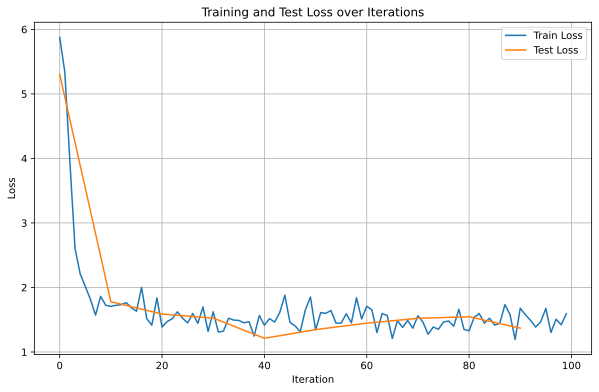

In [12]:
# plot the losses
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot([i * 10 for i in range(len(test_loss))], test_loss, label='Test Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Iterations')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
prompt = 'QUESTION: Where in this world is the best place to retire?'
in2gpt = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0).to(device)

output = gpt2.generate(in2gpt,do_sample=True,max_length=200,pad_token_id=50256)
print(textwrap.fill(tokenizer.decode(output[0]),80))

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


QUESTION: Where in this world is the best place to retire? ANSWER: The most
relaxing time to do retirement is in an environment that you and your family can
enjoy together. If you live in a great city, then retirement will be easier than
in the suburbs due to the convenience of living close to your
kids[2][3][4][5][6][7]. However, while you and your family may be closer in age
and in location to live one could feel more like you are moving to a new
country[3][4][5][5][7], there are many places that you can still live that is
relaxing, peaceful, and enjoyable, and that is where to
retire.[4][5][5]<|endoftext|>
